In [1]:
from keras.datasets import cifar10

(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

170498071/170498071 [==============================] - 2s 0us/step


In [2]:
from keras.utils import to_categorical

train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

train_labels = to_categorical(train_labels, 10)
test_labels = to_categorical(test_labels, 10)

In [3]:
from keras.models import load_model

# 원하는 모델 불러오기
model = load_model('./main_model_0.864.h5')
model.evaluate(test_images,  test_labels, verbose=2)

313/313 - 10s - loss: 0.4914 - acc: 0.8644 - 10s/epoch - 31ms/step


[0.4914080500602722, 0.8644000291824341]

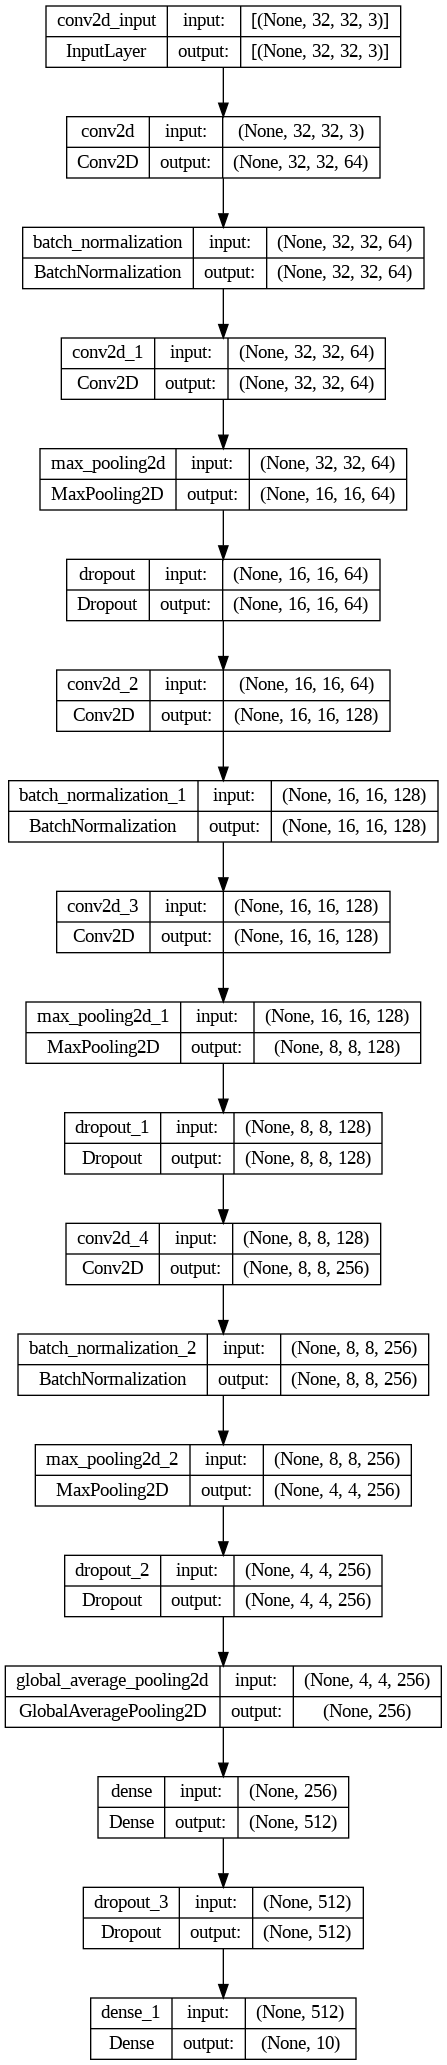

In [4]:
import keras
keras.utils.plot_model(model, show_shapes=True)

<br>
<br>

# T-SNE

## 1. First conv2d layer

아래 코드는 주어진 CNN 모델에서 **맨 처음 conv2d 층**을 사용하여, 테스트 이미지들의 특징을 2,3차원으로 시각화하기 위해 t-SNE(t-distributed Stochastic Neighbor Embedding) 알고리즘을 적용한 것입니다. 

여기에서는 먼저 모델이 만들어내는 특징 맵(feature map)을 가져오고, 이를 t-SNE 알고리즘과 PCA(주성분 분석)를 이용하여 2,3차원 플롯에 표현합니다. 

최종 결과를 확인하기 위해 Seaborn의 scatterplot을 사용하며, 각 데이터 포인트의 클래스 레이블을 색상으로 구분합니다.

In [5]:
from sklearn.manifold import TSNE
import seaborn as sns
from keras.models import Model
import numpy as np
import matplotlib.pyplot as plt

# 중간 레이어 출력 얻기
intermediate_model = Model(inputs=model.input, outputs=model.get_layer('conv2d').output)
intermediate_output = intermediate_model.predict(test_images)

# 차원 축소를 위한 데이터 형태 변경
num_samples, x_shape, y_shape, num_channels = intermediate_output.shape
reshaped_output = np.reshape(intermediate_output, (num_samples, x_shape * y_shape * num_channels))
print(reshaped_output.shape)

313/313 [==============================] - 1s 2ms/step
(10000, 65536)


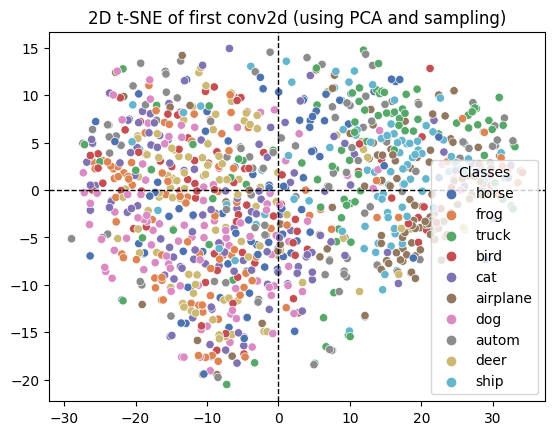

In [6]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 숫자 라벨을 클래스 이름으로 변환하는 사전 정의
label_dict = {
    0: 'airplane',
    1: 'autom',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'}

# PCA를 사용하여 차원 축소
pca = PCA(n_components=50)
pca_output = pca.fit_transform(reshaped_output)

# 샘플링 및 t-SNE 적용
tsne = TSNE(n_components=2)

sample_size = 1000  # 샘플 크기를 조절하 시간을 줄일 수 있습니다. 1~10000
sample_indices = np.random.choice(num_samples, sample_size, replace=False)

sampled_pca_output = pca_output[sample_indices]  # pca 결과를 샘플링하도록 변경
sampled_labels = test_labels[sample_indices]
tsne_output = tsne.fit_transform(sampled_pca_output)  # PCA 결과를 사용하여 t-SNE를 적용합니다.
class_labels = np.argmax(sampled_labels, axis=1)

# 숫자 라벨을 클래스 이름으로 변환
class_labels_text = [label_dict[label] for label in class_labels]

sns.scatterplot(x=tsne_output[:, 0], y=tsne_output[:, 1], hue=class_labels_text, palette="deep")

plt.axhline(0, color='black', linewidth=1, linestyle='dashed')  # y축 점선을 그립니다.
plt.axvline(0, color='black', linewidth=1, linestyle='dashed')  # x축에 점선을 그립니다.

plt.title('2D t-SNE of first conv2d (using PCA and sampling)')
plt.legend(title='Classes')
plt.show()


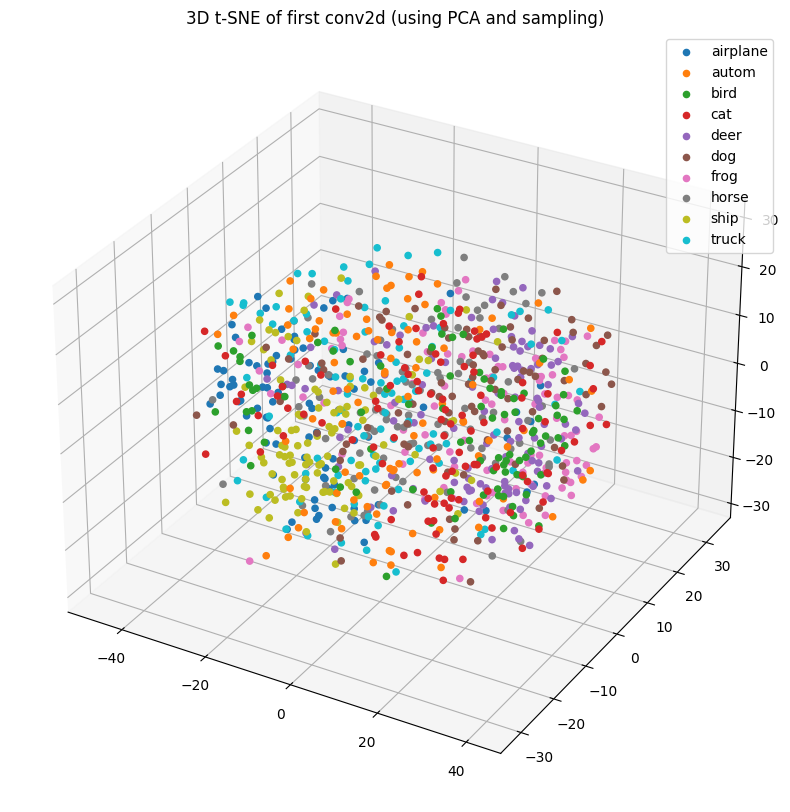

In [7]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt

# 숫자 라벨을 클래스 이름으로 변환하는 사전 정의
label_dict = {
    0: 'airplane',
    1: 'autom',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'}

tsne_3d = TSNE(n_components=3) # 3차원으로 축소
pca = PCA(n_components=50)  # 주성분 분석을 이용해 50 차원으로 줄입니다.
pca_output = pca.fit_transform(reshaped_output)
tsne_output_3d = tsne_3d.fit_transform(pca_output)

sample_size = 1000  # 10000개는 너무 많으므로 샘플링
sample_indices = np.random.choice(num_samples, sample_size, replace=False)

sampled_output = pca_output[sample_indices]
sampled_labels = test_labels[sample_indices]
tsne_output_3d = tsne_3d.fit_transform(sampled_output)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
color_labels = np.argmax(sampled_labels, axis=1)

# 레이블별로 데이터를 분할하고 색상을 지정하여 산점도에 추가
for label in range(10):
    indices = np.argwhere(color_labels == label).flatten()
    ax.scatter(tsne_output_3d[indices, 0], tsne_output_3d[indices, 1], tsne_output_3d[indices, 2], label=label_dict[label], alpha=1)

ax.set_title('3D t-SNE of first conv2d (using PCA and sampling)')
ax.legend()
plt.show()


<br>
<br>

## 2. last dense layer

이번에는 주어진 CNN 모델에서 **맨 마지막 dense 층**을 사용하여, 테스트 이미지들의 특징을 2,3차원으로 시각화하기 위해 t-SNE(t-distributed Stochastic Neighbor Embedding) 알고리즘을 적용한 것입니다.

In [8]:

from sklearn.manifold import TSNE
import seaborn as sns
from keras.models import Model
import numpy as np
import matplotlib.pyplot as plt

# 중간 레이어 출력 얻기
intermediate_model = Model(inputs=model.input, outputs=model.get_layer("dense_1").output)
intermediate_output = intermediate_model.predict(test_images)
num_samples = intermediate_output.shape[0]

# 차원 축소를 위한 데이터 형태 변경 (이 경우 변경할 필요가 없습니다.)
reshaped_output = intermediate_output

print(reshaped_output.shape)


313/313 [==============================] - 1s 3ms/step
(10000, 10)


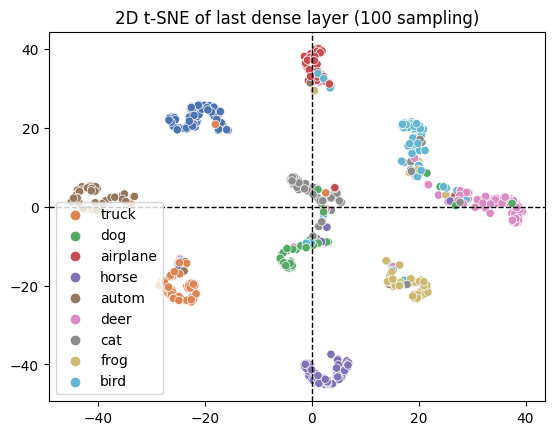

In [12]:
from sklearn.manifold import TSNE
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# 숫자 라벨을 클래스 이름으로 변환하는 사전 정의
label_dict = {
    0: 'airplane',
    1: 'autom',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: '',
    9: 'truck'}

# t-SNE에 의한 차원 축소
tsne = TSNE(n_components=2)

sample_size = 1000  # 샘플 크기
sample_indices = np.random.choice(num_samples, sample_size, replace=False)

sampled_output = reshaped_output[sample_indices]
sampled_labels = test_labels[sample_indices]
tsne_output = tsne.fit_transform(sampled_output)

# 클래스 이름으로 변환한 라벨 생성
converted_labels = np.array([label_dict[label] for label in np.argmax(sampled_labels, axis=1)])

sns.scatterplot(x=tsne_output[:, 0], y=tsne_output[:, 1], hue=converted_labels, palette="deep", legend='full')

plt.axhline(0, color='black', linewidth=1, linestyle='dashed')  # y축에 점선을 그립니다.
plt.axvline(0, color='black', linewidth=1, linestyle='dashed')  # x축에 점선을 그립니다.
plt.title("2D t-SNE of last dense layer (100 sampling)")

plt.show()

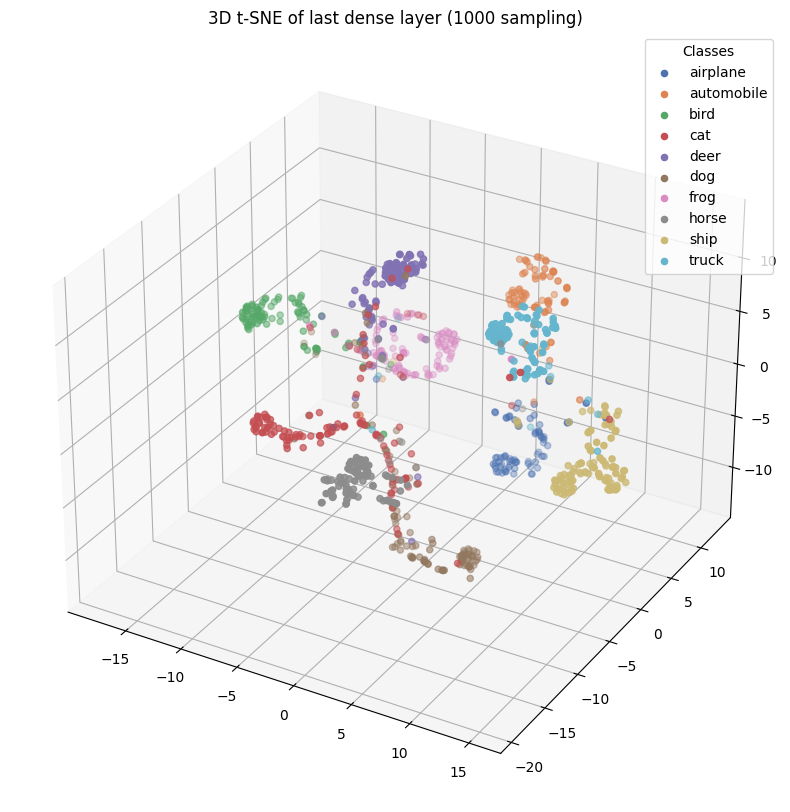

In [15]:
from sklearn.manifold import TSNE
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 숫자 라벨을 클래스 이름으로 변환하는 사전 정의
label_dict = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'}

# t-SNE에 의한 차원 축소
tsne = TSNE(n_components=3)

sample_size = 1000  # 샘플 크기
sample_indices = np.random.choice(num_samples, sample_size, replace=False)

sampled_output = reshaped_output[sample_indices]
sampled_labels = test_labels[sample_indices]
tsne_output = tsne.fit_transform(sampled_output)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")

palette = sns.color_palette("deep", 10)

for i, target in enumerate(np.unique(np.argmax(sampled_labels, axis=1))):
    indices = np.where(np.argmax(sampled_labels, axis=1) == target)
    ax.scatter(
        tsne_output[indices, 0],
        tsne_output[indices, 1],
        tsne_output[indices, 2],
        color=palette[i],
        label=label_dict[target], # 클래스 이름으로 라벨 변경
    )

ax.legend(title='Classes')  # 클래스 이름으로 변환된 범례 추가
plt.title("3D t-SNE of last dense layer (1000 sampling)")
plt.show()
